# Generación de Datasets para el Modeo predictivo

In [1]:
# Importacion de paquetes necesarios
import requests
import json
import pandas as pd
import os
import datetime
from pandas.core.common import flatten
from nltk.corpus import stopwords
import pandas as pd
from pandas.core.common import flatten
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.metrics import accuracy_score
import datetime
import numpy as np
pd.set_option('display.max_rows', 40)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

#### En archivo config.json tengo los datos de condifiguración para generar el ACCESS_TOKEN, necesario para hacer las querys

In [2]:
try:
    with open('../config/config.json') as file:
        settings = json.load(file)
except Exception as e:
    print(e)
    
APP_ID= settings["APP_ID"]
SECRET_KEY= settings["SECRET_KEY"]
REDIRECT_URI= settings["REDIRECT_URI"]


#### Accediendo a este Link obtengo el SERVER_GENERATED_AUTHORIZATION_CODE que se agrega al archivo de configuración para luego hacer 

In [3]:
(f"http://auth.mercadolibre.com.ar/authorization?response_type=code&client_id={APP_ID}&redirect_uri={REDIRECT_URI}")


'http://auth.mercadolibre.com.ar/authorization?response_type=code&client_id=4736838571701537&redirect_uri=https://www.google.com/'

In [ ]:
SERVER_GENERATED_AUTHORIZATION_CODE= "TG-5f258aab236b3c00066563de-46180769"
response = requests.post(url = f"https://api.mercadolibre.com/oauth/token?grant_type=authorization_code&client_id={APP_ID}&client_secret={SECRET_KEY}&code={SERVER_GENERATED_AUTHORIZATION_CODE}&redirect_uri={REDIRECT_URI}")
item = json.loads(response.content)
print(item)
ACCESS_TOKEN = item["access_token"]


In [ ]:
category = requests.get("https://api.mercadolibre.com/sites/MLA/categories")
category = json.loads(category.content)
category_id =[x["id"] for x in category]

#### Para el modelo predictivo se asume que se va a querer predecir los articulos más relevantes por mercado libre que aparecerian al principio de las busquedas y por lo tanto tambien aparecen usando el servicio https://api.mercadolibre.com/sites/MLA/search?category=. Entonces se llamaran 10000 busquedas por categoría para luego samplear un 20% del total. Este servicio no entrega los features más relevantes para el modelo predictivo como todas las fechas relacionadas a la creación , actualización y cierre de la publicación, por lo que se usaran estos IDs para aplicar en el servicio de búsqueda por IDs.

In [ ]:
sample= []
folder = "data_predictive"
os.makedirs("data_predictive", exist_ok=True)
for categ_id in category_id:
    print(categ_id)
    for offset in range(0, 10000 ,50):
        query = requests.get(f"https://api.mercadolibre.com/sites/MLA/search?category={categ_id}&offset={offset}&access_token={ACCESS_TOKEN}")
        item = json.loads(query.content)["results"]
        [x.update({"category_id":categ_id}) for x in item]
        sample = item + sample
with open(os.path.join(folder , 'sold_ids.json'), 'w') as fp:
    json.dump(sample, fp)

In [19]:
folder = "data_predictive"
with open(os.path.join(folder , 'sold.json'), 'r') as fp:
    sold = json.load(fp)
df = pd.Series([x["id"] for x in sold])

#### Sampleamos un 20% de esos IDs de publicaciones más relevantes y usamos el servicio https://api.mercadolibre.com/items/ID para encontrar los datos más relevantes para predecir la cantidad vendidad.

In [14]:
df_sample = df.sample(frac = 0.2, random_state = 1)


In [16]:
new_features = []
item_atri = {}
for n,i in enumerate(df_sample["id"]):
    if n%5000 == 0:
        print(n,i)
    query = requests.get(f"https://api.mercadolibre.com/items/{i}")
    item = json.loads(query.content)
    new_features.append(item)
with open(os.path.join(folder , 'sold_dfj.json'), 'w') as fp:
    json.dump(new_features, fp)

0 MLA833724782
5000 MLA862591091
10000 MLA811171228
15000 MLA823511152
20000 MLA870881965
25000 MLA762116528
30000 MLA745143539
35000 MLA642843152
40000 MLA865456284
45000 MLA838258439
50000 MLA659132409
55000 MLA840325531
60000 MLA829434263


#### Guardamos el las 60000 filas de nuestro dataframe para predecir la cantidad vendidas.
#### Procedemos a hacer las transformaciones básicas para que nuestro dataset pueda ser interpretado por un algoritmo.

In [103]:
folder = "data_predictive"
with open(os.path.join(folder , 'sold_dfj.json'), 'r') as fp:
    sold = json.load(fp)

In [104]:
def mowing_json(dict_input): # Descartamos ramas del json que no son de interes en el analisis.
    dict_mowing  = dict_input.copy()
    dict_mowing.pop("attributes", None)
    dict_mowing.pop("pictures", None)
    dict_mowing.pop("permalink", None)
    dict_mowing.pop("variations", None)
    dict_mowing.pop("thumbnail", None)
    dict_mowing.pop("sale_terms", None)
    dict_mowing.pop("secure_thumbnail", None)
    dict_mowing.pop("video_id", None)
    dict_mowing.pop("subtitle", None)
    dict_mowing.pop("site_id", None)
    dict_mowing.pop("seller_address", None)
    dict_mowing.pop("official_store_id", None)
    dict_mowing.pop("warnings", None)
    dict_mowing.pop("seller_contact", None)
    dict_mowing.pop("international_delivery_mode", None)
    dict_mowing.pop("sub_status", None)
    dict_mowing.pop("catalog_product_id", None)
    dict_mowing.pop("parent_item_id", None)
    dict_mowing.pop("differential_pricing", None)
    dict_mowing.pop("listing_source", None)
    dict_mowing.pop("location", None)
    dict_mowing.pop("non_mercado_pago_payment_methods", None)
    dict_mowing.pop("coverage_areas", None)
    dict_mowing.pop("deal_ids", None)
    dict_mowing.pop("seller_id", None)
    dict_mowing.pop("descriptions", None)


    return dict_mowing
df_json = [mowing_json(x) for x in sold] # Aplica funcon de podado en Json
df = pd.json_normalize(df_json,sep="_") # Transformo Json a DataFrame
df = df.infer_objects()  # Inferimos el mejor tipo de dato para la columna
df = df.replace('', np.nan) # Reemplazo espacios vacios por NaN

#### Convertimos las variables categoricas con jerarquia con un label encoder que mantenga el orden jerarquico entre los niveles
#### Las variables que no tienen una repesetenación jerarquica son convertidas en variables dummies booleanas.
#### Imputamos algunos valores faltantes y eliminamos 

In [105]:
df["listing_type_id"] =df["listing_type_id"].map({'gold_special':6, 'gold_premium': 5, "gold_pro": 4,'gold':3, 'silver': 2, "bronze": 1,"free": 1})
df = pd.concat([df.drop('buying_mode', axis=1), pd.get_dummies(df['buying_mode'], prefix="bmode_")], axis=1)
df = pd.concat([df.drop('currency_id', axis=1), pd.get_dummies(df['currency_id'], prefix="currency_")], axis=1)
df = pd.concat([df.drop('shipping_logistic_type', axis=1), pd.get_dummies(df['shipping_logistic_type'], prefix="slog_")], axis=1)
df = pd.concat([df.drop('shipping_mode', axis=1), pd.get_dummies(df['shipping_mode'], prefix="smd_")], axis=1)
df = pd.concat([df.drop('status', axis=1), pd.get_dummies(df['status'])], axis=1)
df = pd.concat([df.drop('condition', axis=1), pd.get_dummies(df['condition'])], axis=1)

df["health"].fillna(df["health"].mean(),inplace=True)
df["original_price"].fillna(0,inplace=True)
df["geolocation_latitude"].fillna(0,inplace=True)
df["geolocation_longitude"].fillna(0,inplace=True)
df = df.drop(df[df["available_quantity"].isnull()].index)


#### Las variables relacionadas al tiempo se las transforma a la cantidad de días de diferencia con respecto al día en que se generaron las consultas. Es importante entender que la variable Sold va a depender del tiempo en que se decida predecir una publicación. Consecuentes predicccions realizadas sobre una publicación a lo largo del tiempo deben dar resultados distintos dado que una publicación solo va a aumentar la cantidad de articulos vendidos. En el caso que se quiera predecir articulos en producción hay que transformar estas variables acorde con la fecha en que se consultaron en la API.

In [106]:
datetime_features = ["start_time","stop_time","last_updated","date_created"]
call_date = datetime.datetime(2020, 8,1)
for feat in datetime_features:
    df[feat] = pd.to_datetime(df[feat], utc=True).dt.tz_localize(None)
    df[f"{feat}_days"] = (df[feat]- call_date).apply(lambda x : x.days)
df.drop(datetime_features, axis= 1 ,inplace =True, errors='ignore')

stopwords_es =  stopwords.words('spanish')
def title2word( title):
    return len(([x for x in title.strip().lower().split(" ") if x not in stopwords_es]))
df["title_words"] = df["title"].apply(title2word)
df = df.drop(df[df.duplicated(subset=['id'],keep="first")].index)

#### Tambien eliminamos variables que no van a aportar mucho valor a las predicciones

In [107]:
df["tags"] = df["tags"].apply(len)
df["shipping_tags"] = df["shipping_tags"].apply(len)

In [108]:
df=df.drop(["tags","domain_id","shipping_tags","id","title","warranty","category_id","shipping_dimensions","shipping_methods","shipping_free_methods"],axis=1,errors="ignore")
df = df.drop(df[df["price"].isnull()].index)

#### Se decidio categorizar la variable a predecir dado que el servicio de API https://api.mercadolibre.com/sites/MLA/search?category= encuadra la cantidad vendidda dentro de estos rangos:

In [109]:
def categ_sold(x):
    if 5<= x<=50:
        x=5
    elif 51<= x<=100:
        x=50
    elif 101<= x<=150:
        x=100
    elif 151<= x<=200:
        x=150
    elif 201<= x<=250:
        x=200
    elif 251<= x<=500:
        x=250    
    elif 501<= x<=5000:
        x=500    
    elif 5001<= x<=50000:
        x=5000      
    return x

In [110]:
df["sold_quantity"]=df["sold_quantity"].apply(lambda x: categ_sold(x)).astype("int")
df.reset_index(inplace=True,drop=True)

#### Verificamos la distribución de la variable a predecir y notamos que hay un gran desbalance entre las distintas clases, especialmente la clase de mayoritaria que representan el 50% de los valores. Mantegamos este valor en mente como la predicción dummy que uno podría llegar a hacer

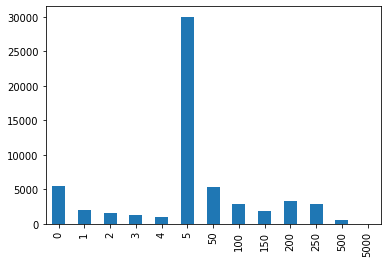

In [35]:
df["sold_quantity"].value_counts().sort_index().plot.bar()

#### Guardamos nuestro Dataset

In [11]:
df[["initial_quantity","available_quantity"]] =  df[["initial_quantity","available_quantity"]].astype("int")
df.to_csv("data_predictive/clean_sold.csv")

### Hacemos una predicción sin optimización en default para testear que valores podemos encontrarnos.

In [ ]:
y = df["sold_quantity"]
X = df.drop(["sold_quantity"],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

In [13]:
rf = RandomForestClassifier()
rf.fit(X_train,y_train)

RandomForestClassifier()

In [14]:
predictions = rf.predict(X_test)

In [16]:
cross_val_score(rf,X_train,y_train,cv=5)

array([0.70658462, 0.71778462, 0.71975385, 0.71889231, 0.71926154])